In [3]:
%matplotlib notebook
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os

In [4]:
epsilon = 1e-12
print(epsilon)

1e-12


# Utilities

In [5]:
def calc_acceleration(r, n, d, G, m, **unused):
    a = np.zeros([n, d])
    
    # For all indicies where j!=i, summing over js
    # j is row index, i is column    
    for i in range(n):
        for j in range(n):
            if i != j:
                #r_norm = np.linalg.norm(r[j]-[i])
                r_norm = np.sqrt((r[j][0]-r[i][0])**2 + (r[j][1]-r[i][1])**2)
                a[i][0] += G*m[j] * (r[j][0]-r[i][0])/r_norm**3
                a[i][1] += G*m[j] * (r[j][1]-r[i][1])/r_norm**3
                
    return a

In [6]:
def calc_energy(r, v, n, G, m, **unused):
    kin = 0
    pot = 0
    x, y = r[:,0], r[:, 1]
    vx, vy = v[:,0], v[:, 1]
    for i in range(n):
        kin += 0.5 * m[i]*(vx[i]*vx[i] + vy[i]*vy[i])
        for j in range(i+1, n):
            dist = np.sqrt((r[j][0]-r[i][0])**2 + (r[j][1]-r[i][1])**2)
            pot -= G*m[i]*m[j]/dist
    return kin, pot

In [7]:
def calc_angular_momentum(r, v):
    return np.cross(r, v) # Note: numpy.cross returns a scalar if both vectors are 2D

In [8]:
def calc_runge_lenz(r, v, j, m, G, d, **unused):
    cross = j[:, np.newaxis]*v[:,[1,0]]
    #cross[:,0] *= -1
    
    return (cross/(G*np.sum(m))) - (r/(np.linalg.norm(r, axis=1, keepdims=True)))

In [9]:
def calc_sma(j, e, m, G, n, d, **unused):
    # Returns the semi-major axis calculated with the
    # current position, angular momentums and runge-lenz vector
    #return ((j**2)/(G*np.sum(m))) / (1 - np.linalg.norm(e)**2)
    #e_norm = 
    denom = (1 - (np.linalg.norm(e, axis=1))**2)
    if denom.any() == 0:
        denom = denom + epsilon
    return ((j**2)/(G*np.sum(m))) / denom

In [10]:
def calc_jerk(r, v, n, d, G, m):
    """ Takes the current position and velocity vectors, and returns a vector with jerk values. """
    jerk = np.zeros([n, d])
    for i in range(n):
        for j in range(i+1, n):
            if i != j:
                rij = r[j] - r[i]
                #print("rij: ", rij)
                #print("t1: ", r[j][0] - r[i][0])
                #print("t2: ", rij[0])
                r_norm = np.sqrt((r[j][0]-r[i][0])**2 + (r[j][1]-r[i][1])**2)
                vij = v[j] - v[i]
                #jerk[i][0] += G*m[j]*((vij[0]/(np.linalg.norm(rij)**3)) - 3*((vij[0]*rij[0])/(np.linalg.norm(rij)**5))*rij[0])
                #jerk[i][1] += G*m[j]*((vij[1]/(np.linalg.norm(rij)**3)) - 3*((vij[1]*rij[1])/(np.linalg.norm(rij)**5))*rij[1])
                jerk[i][0] += G*m[j]*((vij[0]/(r_norm**3)) - 3*((vij[0]*rij[0])/(r_norm**5))*rij[0])
                jerk[i][1] += G*m[j]*((vij[1]/(r_norm**3)) - 3*((vij[1]*rij[1])/(r_norm**5))*rij[1])
                #print("jerk: ", jerk)
    return jerk

## Adaptive Timestep

In [11]:
# In exercise 2, everything should initially be done with a fixed timestep, and then re-run
# with an adaptive timestep

def fixed_timestep(P, div):
    fixed_time_step = (1.0/div)*P       # Time per integration step (FIXED)
    return fixed_time_step

def adaptive_timestep(eta, r, v, a, n, d, G, m, **unused):
    jerk = calc_jerk(r, v, n, d, G, m)
    #print(np.linalg.norm(a, axis=1)/(np.linalg.norm(jerk, axis=1) + epsilon))
    #print("r: ", r)
    #print("v: ", v)
    #print("|a|: ", np.linalg.norm(a, axis=1))
    #print("|j|: ", np.linalg.norm(jerk, axis=1))
    #print("eta: ", eta)
    dt = eta*np.min(np.linalg.norm(a, axis=1)/(np.linalg.norm(jerk, axis=1) + epsilon))
    #print("dt: ", dt)
    return dt

# Integration Methods

## Ex1: Euler

In [12]:
def euler(r, v, a, dt, params):
    a = calc_acceleration(r, **params)
    r = r + v*dt
    v = v + a*dt # v = [vx, vy]
    return r, v, a

## Ex1: Euler-Cromer

In [13]:
def euler_cromer(r, v, a, dt, params):
    a = calc_acceleration(r, **params)
    v = v + a*dt
    r = r + v*dt
    return r, v, a

## Ex1: Velocity Verlet

In [14]:
def v_verlet(r, v, a, dt, params):
    v_tmp = v + 0.5*dt*a
    r = r + dt*v_tmp
    a = calc_acceleration(r, **params)
    v = v_tmp + 0.5*dt*a
    return r, v, a

## Ex1: RK4

In [15]:
def rk4_helper(X, params):
    r, v = X
    a = calc_acceleration(r, **params)
    return np.array([v, a])

def rk4(r, v, a, dt, params):
    # We want to find K values for r and v simultaneously, so we'll make a vector [r, v]
    X = np.array([r, v])
    
    K1 = dt*rk4_helper(X, params)
    K2 = dt*rk4_helper(X + 0.5*K1, params)
    K3 = dt*rk4_helper(X + 0.5*K2, params)
    K4 = dt*rk4_helper(X + K3, params)
    
    X += (1/6)*(K1 + 2*K2 + 2*K3 + K4)
    r, v = X
    a = calc_acceleration(r, **params)
    
    return r, v, a

# Ex2: Application to the two-body problem

## Setup

In [16]:
def n_body_init(init_r, init_v, params, n, d, G, m):
    """Returns initial values for position, velocity and acceleration
    init_r: list/array of length n containing initial positions (vectors of length d)
    init_v: list/array of length n containing initial velocities (vectors of length d)
    """
    
    r = np.array(init_r)
    v = np.array(init_v)
    
    # MOVE TO CENTER OF MASS SYSTEM
    
    # Instead of m1 and m2, we have the total mass M and the reduced mass mu
    M_total = np.sum(m)
    
    # Set the origin of our system at the center of mass
    rcm = np.zeros(d)
    vcm = np.zeros(d)
    
    # Compute center of mass location
    # Note: R = (1/M)*sum(mi*ri) is the location of the center of mass (ri is the
    # vector with the coordinates of the ith object)
    rcm += (m @ r)/M_total 
    vcm += (m @ v)/M_total
    
    # Vector subtraction to move r, v relative to COM
    r -= rcm
    v -= vcm

    # Initial acceleration
    
    a = calc_acceleration(r, **params) # Calculate acceleration for rs[0]
    
    # Other measured values
    
    kin, pot = calc_energy(r, v, **params)
    j = calc_angular_momentum(r, v)
    e = calc_runge_lenz(r, v, j, **params)
    sma = calc_sma(j, e, **params)
        
    return r, v, a, kin, pot, j, e, sma

In [17]:
def solve_two_body(integrator, timestep='fixed', div=500):
    # Number of spatial dimensions
    d = 2
    
    # Handle inital values and settings for two bodies
    n = 2               # Number of bodies
    P = 2*np.pi         # Period (given as 2pi)
    t_max = 10*P        # Time at which the integration ends
    G = 1.0

    # Initial values (1=star, 2=planet)
    m1 = 1.0     # Mass
    m2 = 10**-3
    m = np.array([m1, m2])

    e = 0.5     # Eccentricity of orbit
    sma = 1.0     # Semi-major axis
    
    params = {'n':n, 'd':d, 'G':G, 'm':m}
    
    # Initial position and velocity
    x = sma*(1 + e)
    y = 0
    
    vx = 0
    vy = np.sqrt((G*(m[0] + m[1])/sma)*((1-e)/(1+e)))
    
    init_r = [[0,0], [x, y]]
    init_v = [[0,0], [vx, vy]]
    
    r, v, a, kin, pot, j, e, sma = n_body_init(init_r, init_v, params, **params)
    dt = fixed_timestep(P, div) 
    
    ts = []     # Time
    rs = []     # Position
    vs = []     # Velocity
    accs = []   # Acceleration
    Es = []     # Energy
    kins = []   # Kinetic
    pots = []   # Potential
    js = []     # Specific angular momentum
    es = []     # Runge-Lenz vector (eccentricity)
    smas = []   # Semi-major axis
    
    # Save initial values
    ts.append(0) 
    rs.append(r)
    vs.append(v)
    #accs.append(a)
    Es.append(kin + pot)
    js.append(j)
    es.append(e)
    smas.append(sma)
    pots.append(pot)
    kins.append(kin)
    
    # Run the integrator
    t = 0
    
    #prog = tqdm(total = t_max) # Progress bar
    
    start_time = time.time() # Measure how long the integrator takes
    
    while t < t_max:
        r, v, a = integrator(r, v, a, dt, params)
        kin, pot = calc_energy(r, v, **params)
        j = calc_angular_momentum(r, v)
        e = calc_runge_lenz(r, v, j, **params)
        sma = calc_sma(j, e, **params)
        
        # Timestep
        dt = fixed_timestep(P, div) 
        if timestep == 'adaptive':
            dt = adaptive_timestep(dt, r, v, a, **params)
        
        ts.append(t) 
        rs.append(r)
        vs.append(v)
        accs.append(a)
        Es.append(kin + pot)
        js.append(j)
        es.append(e)
        smas.append(sma)
        pots.append(pot)
        kins.append(kin)
        
        t += dt
    
        #prog.update(1) # increment progress bar
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    
    print("Done! (with method " + integrator.__name__ + ", timestep = " + timestep + " and div = " + str(div) + ")")
    print("Took: " + str(time_elapsed) + " seconds")
    
    ts = np.array(ts)
    rs = np.array(rs)
    vs = np.array(vs)
    accs = np.array(accs)
    Es = np.array(Es)
    js = np.array(js)
    es = np.array(es)
    smas = np.array(smas)
    kins = np.array(kins)
    pots = np.array(pots)
    
    return ts, rs, vs, accs, Es, js, es, smas, kins, pots

In [22]:
# Dictionary for results at different timesteps
if 'euler_res' not in locals():
    euler_res = {}
    euler_cromer_res = {}
    v_verlet_res = {}
    rk4_res = {}
divs = [10, 50, 100, 500, 1000]

# RUN HERE FOR FIXED
## Only need to run this once. It runs for all timesteps and all integrators. No harm in running it twice if done accidentally though.

In [23]:
run_all = True
timestep = 'fixed'
#div = 10
#method = 'rk4'

for div in divs:
    if method == 'euler' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(euler, timestep, div)
        euler_res[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'euler_cromer' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(euler_cromer, timestep, div)
        euler_cromer_res[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'v_verlet' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(v_verlet, timestep, div)
        v_verlet_res[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'rk4' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(rk4, timestep, div)
        rk4_res[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]

Done! (with method euler, timestep = fixed and div = 10)
Took: 0.04203343391418457 seconds
Done! (with method euler_cromer, timestep = fixed and div = 10)
Took: 0.04145216941833496 seconds
Done! (with method v_verlet, timestep = fixed and div = 10)
Took: 0.04015469551086426 seconds
Done! (with method rk4, timestep = fixed and div = 10)
Took: 0.045004844665527344 seconds
Done! (with method euler, timestep = fixed and div = 50)
Took: 0.16207051277160645 seconds
Done! (with method euler_cromer, timestep = fixed and div = 50)
Took: 0.1381521224975586 seconds
Done! (with method v_verlet, timestep = fixed and div = 50)
Took: 0.23833036422729492 seconds
Done! (with method rk4, timestep = fixed and div = 50)
Took: 0.31549930572509766 seconds
Done! (with method euler, timestep = fixed and div = 100)
Took: 0.33286023139953613 seconds
Done! (with method euler_cromer, timestep = fixed and div = 100)
Took: 0.3175933361053467 seconds
Done! (with method v_verlet, timestep = fixed and div = 100)
Took:

# Ex. 2.2 Plot the orbit trajectories

In [24]:
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
method = 'v_verlet' #
res = locals()[method + '_res']
div = 1000

ts = res[div][0]
rs = res[div][1]

r_fig = plt.figure()
plt.scatter(rs[:,0,0], rs[:,0,1], s=1, label="Star") # SUN --> (x,y)
plt.scatter(rs[:,1,0], rs[:,1,1], s=1, label="Planet") # PLANET --> (x,y)

plt.title("Two-body Orbit (r), " + method + ", timestep = P/" + str(div))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# override = False
# filepath = savepath + "/ex2_2" + "/orbit_" + str(div) + "_" + method + ".pdf"
# if not os.path.isfile(filepath) or override:
#     plt.savefig(filepath)
#     print("saved image")
# else: 
#     print("image already exists")

<IPython.core.display.Javascript object>

# Ex. 2.4.1 - compare energy conservation between integrators

In [25]:
# Energy comparison between integrators
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

E_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res']
    div = 1000

    ts = res[div][0]
    Es = res[div][4]
    kins = res[div][8]
    pots = res[div][9]

    shift = -np.min(pots)

    plt.plot(ts, Es + shift, label=method)
    #plt.plot(ts, kins, label="Kinetic")
    #plt.plot(ts, pots + shift, label="Potential")

plt.title("Energy for All Integrators\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("Total Energy + initial potential energy")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/energy_comp_1_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

E_fig = plt.figure()

for method in methods:
    if method != 'euler':
        res = locals()[method + '_res']
        div = 1000

        ts = res[div][0]
        Es = res[div][4]
        kins = res[div][8]
        pots = res[div][9]

        shift = -np.min(pots)

        plt.plot(ts, Es + shift, label=method)
        #plt.plot(ts, kins, label="Kinetic")
        #plt.plot(ts, pots + shift, label="Potential")

plt.title("Energy for all Integrators except Euler\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("Total Energy + initial potential energy")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/energy_comp_2_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

E_fig = plt.figure()

for method in methods:
    if method != 'euler' and method != 'euler_cromer':
        res = locals()[method + '_res']
        div = 1000

        ts = res[div][0]
        Es = res[div][4]
        kins = res[div][8]
        pots = res[div][9]

        shift = -np.min(pots)

        plt.plot(ts, Es + shift, label=method)
        #plt.plot(ts, kins, label="Kinetic")
        #plt.plot(ts, pots + shift, label="Potential")

plt.title("Energy for v_verlet vs. RK4\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("Total Energy + initial potential energy")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/energy_comp_3_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ex. 2.4.1 - compare angular momentum between integrators

<IPython.core.display.Javascript object>


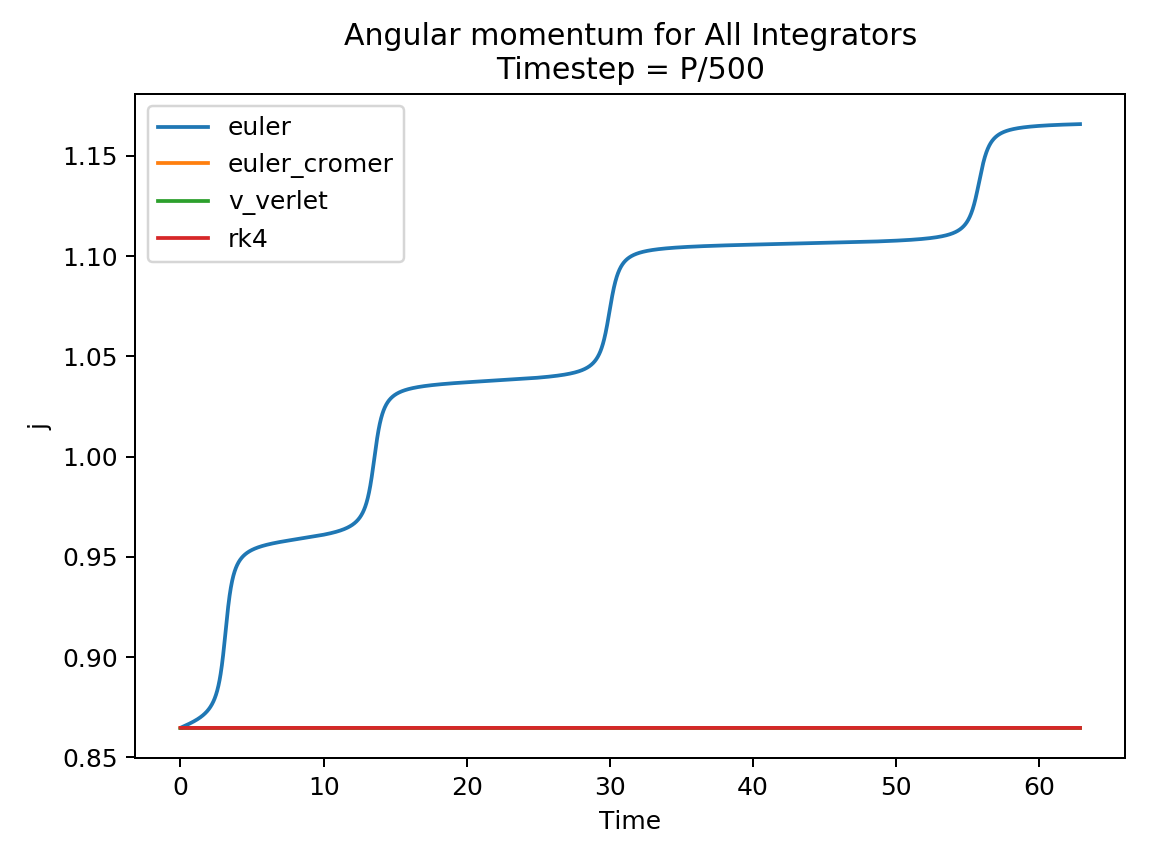

<IPython.core.display.Javascript object>


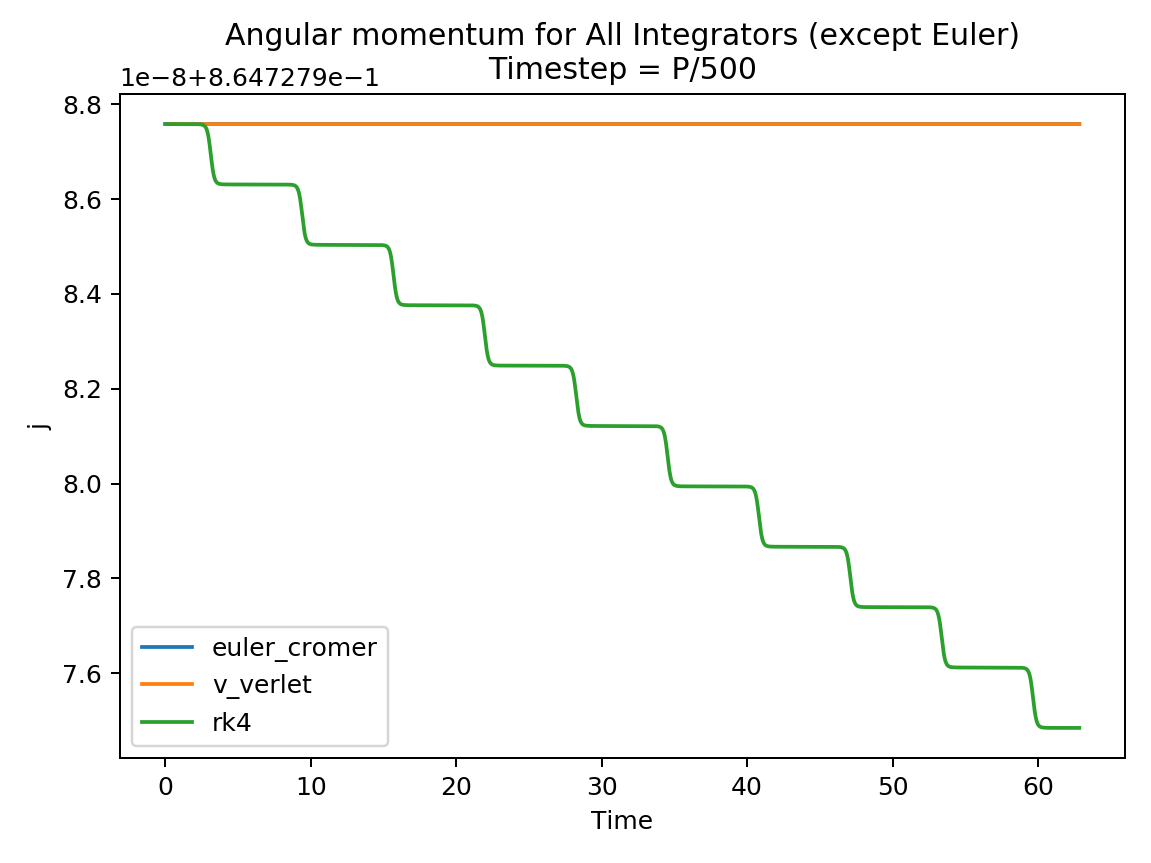

<IPython.core.display.Javascript object>


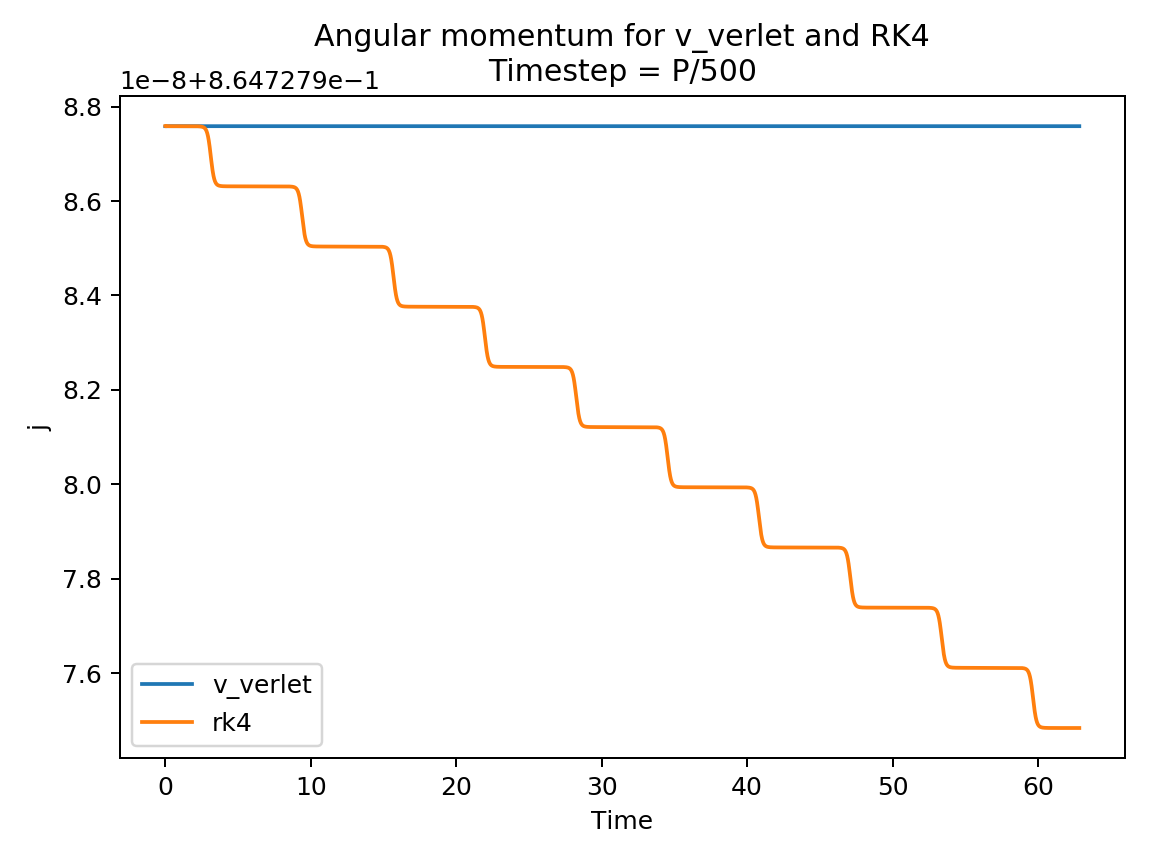

In [27]:
# Angular momentum comparison between integrators
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

j_fig = plt.figure()
    
for method in methods:
    #if method != 'euler':
    res = locals()[method + '_res']
    div = 500

    ts = res[div][0]
    js = res[div][5]

    plt.plot(ts, js[:,1], label=method)

plt.title("Angular momentum for All Integrators\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("j")
#plt.yscale('log')
#plt.ylim([7*10**-8.64, 8.8*10**-8.64])
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/angular_momentum_comp_1_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

# Without euler
j_fig2 = plt.figure()
    
for method in methods:
    if method != 'euler':
        res = locals()[method + '_res']
        div = 500

        ts = res[div][0]
        js = res[div][5]

        plt.plot(ts, js[:,1], label=method)

plt.title("Angular momentum for All Integrators (except Euler)\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("j")
#plt.yscale('log')
#plt.ylim([7*10**-8.64, 8.8*10**-8.64])
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/angular_momentum_comp_2_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

# Without euler_cromer either
j_fig2 = plt.figure()
    
for method in methods:
    if method != 'euler' and method !="euler_cromer":
        res = locals()[method + '_res']
        div = 500

        ts = res[div][0]
        js = res[div][5]

        plt.plot(ts, js[:,1], label=method)

plt.title("Angular momentum for v_verlet and RK4\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("j")
#plt.yscale('log')
#plt.ylim([7*10**-8.64, 8.8*10**-8.64])
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/angular_momentum_comp_3_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

# Ex. 2.4.1 - compare runge-lenz vector between integrators

<IPython.core.display.Javascript object>


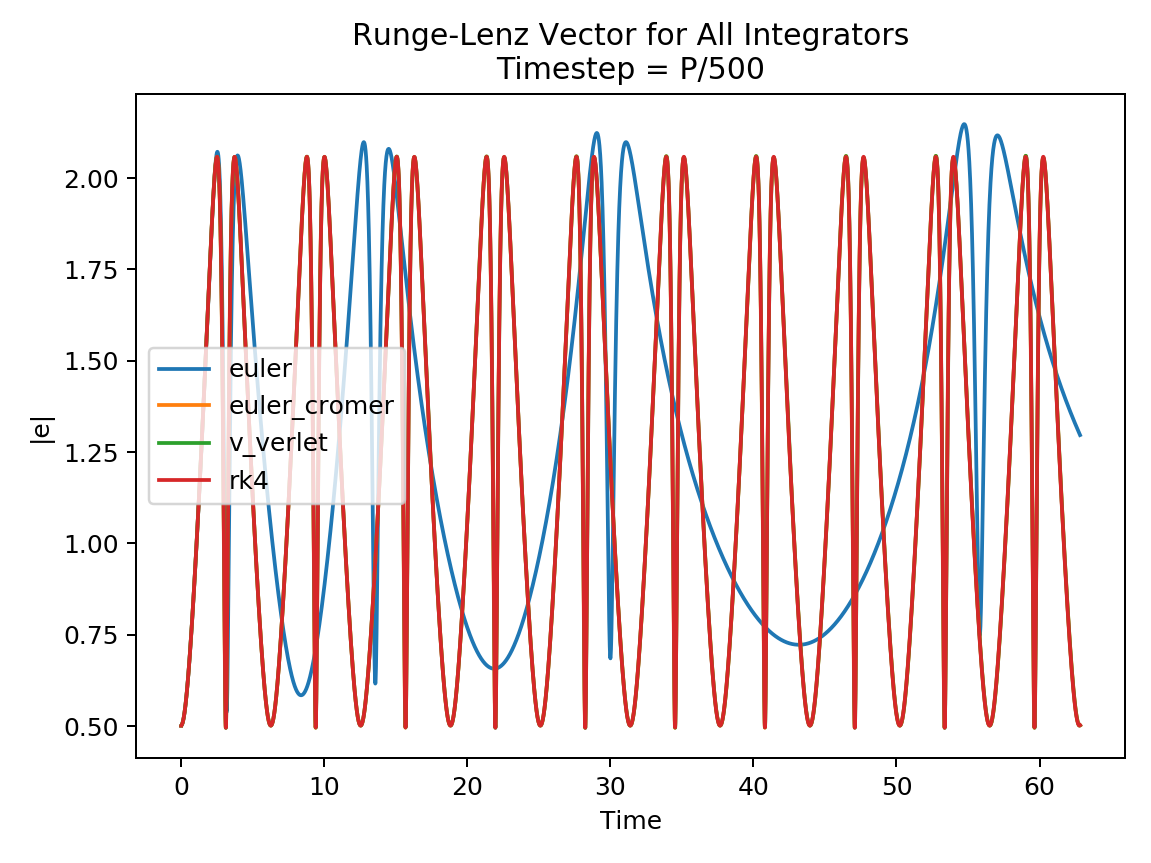

<IPython.core.display.Javascript object>


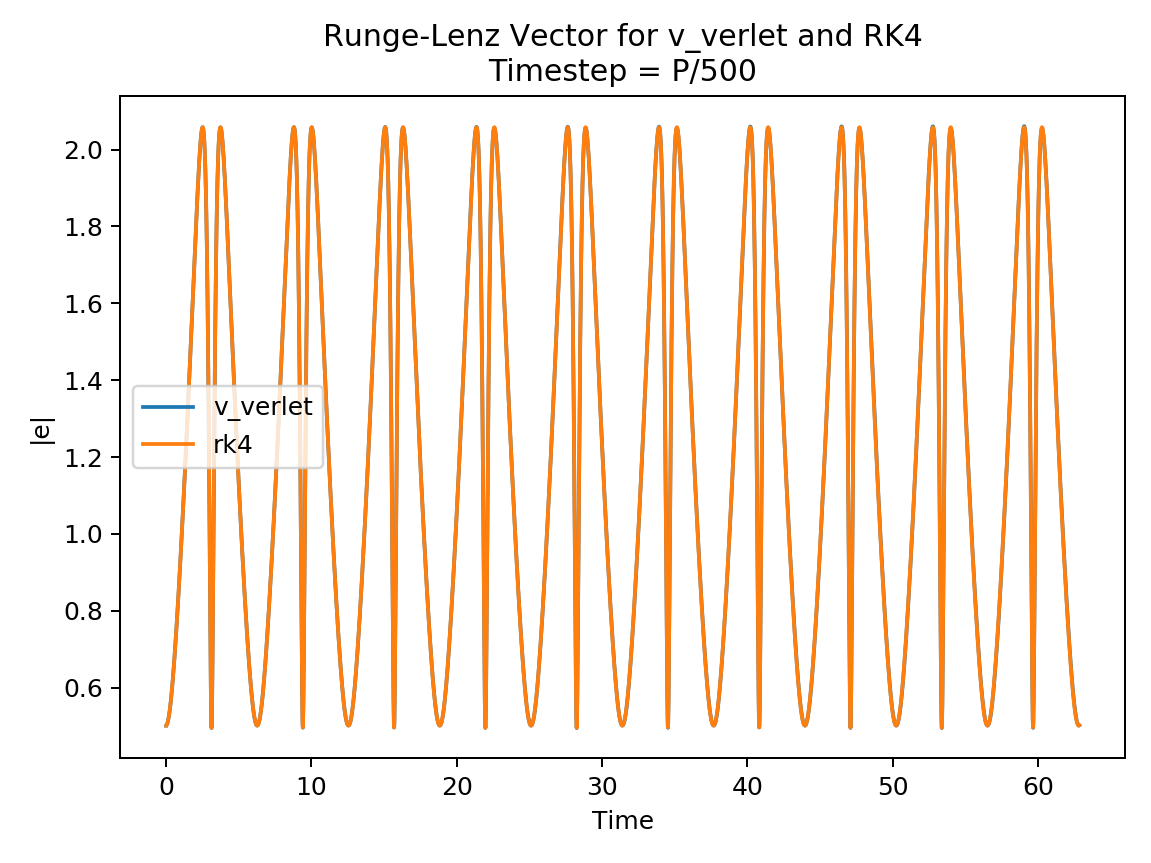

In [28]:
# Runge-lenz comparison between integrators
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

e_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res']
    div = 500

    ts = res[div][0]
    es = res[div][6]

    e_vector = []
    for e in es[:,1]:
        e_vector.append(np.sqrt(e[0]**2 + e[1]**2))
    
    plt.plot(ts, e_vector, label=method)

plt.title("Runge-Lenz Vector for All Integrators\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("|e|")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/ecc_comp_1_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

e_fig = plt.figure()
for method in methods:
    if method != 'euler' and method !="euler_cromer":
        res = locals()[method + '_res']
        div = 500

        ts = res[div][0]
        es = res[div][6]

        e_vector = []
        for e in es[:,1]:
            e_vector.append(np.sqrt(e[0]**2 + e[1]**2))

        plt.plot(ts, e_vector, label=method)

plt.title("Runge-Lenz Vector for v_verlet and RK4\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("|e|")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" + "/ecc_comp_2_" + str(div) + ".pdf"
# #plt.savefig(filepath)
# print("saved image")

# Ex. 2.4.1 - compare semi-major axis (sma) between integrators

In [29]:
# SMA comparison between integrators
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

sma_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res']
    div = 500

    ts = res[div][0]
    smas = res[div][7]

    plt.plot(ts, smas[:,1], label=method)

plt.title("Semi-major Axis for All Integrators\nTimestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("sma")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/ex2_4_1" +"/sma_comp_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

<IPython.core.display.Javascript object>

# Ex. 2.4.2 - compare energy error between integrators

In [30]:
# Energy accuracy measure COMPARISON
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]

E_acc_fig = plt.figure()

for method in methods:
    res = locals()[method + '_res']
    div = 10

    ts = res[div][0]
    Es = res[div][4]
    E_acc = []
    for E in Es:
        E_acc.append(np.abs((E - Es[0])/Es[0]))

    plt.plot(ts, E_acc, label=method)

plt.legend()
plt.title("Energy Error, timestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("log|($E - E^{start}$)/$E^{start}$|")
plt.yscale('log')

# filepath = savepath + "/ex2_4_2" + "/E_acc_comp_" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

<IPython.core.display.Javascript object>

# Ex. 2.4.2 - compare runge-lenz vector between integrators

In [31]:
# Eccentricity accuracy measure COMPARISON
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]

e_acc_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res']
    div = 500

    ts = res[div][0]
    es = res[div][6]
    e_vector = []
    for e in es[:,1]:
        e_vector.append(np.sqrt(e[0]**2 + e[1]**2))
    es = e_vector
    e_acc = []
    for e in es:
        e_acc.append(np.abs((e - es[0])/es[0]))

    plt.plot(ts, e_acc, label=method)

plt.legend()
plt.title("Runge-Lenz Vector Error, timestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("log|($e - e^{start}$)/$e^{start}$|")
plt.yscale('log')

# filepath = savepath + "/ecc_acc_comp" + str(div) + ".pdf"

# plt.savefig(filepath)
# print("saved image")

<IPython.core.display.Javascript object>

# Ex. 2.4.2 - compare sma between integrators

In [32]:
# SMA accuracy measure
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]

sma_acc_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res']
    div = 500

    ts = res[div][0]
    smas = res[div][7]
    sma_acc = []
    for sma in smas[:,1]:
        sma_acc.append(np.abs((sma - smas[0][1])/smas[0][1]))

    plt.plot(ts, sma_acc, label=method)

plt.legend()
plt.title("Semi-major Axis Error, timestep = P/" + str(div))
plt.xlabel("Time")
plt.ylabel("log|($a - a^{start}$)/$a^{start}$|")
plt.yscale('log')

# filepath = savepath + "/sma_acc_comp" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

<IPython.core.display.Javascript object>

# Exercise 2.5: adaptive time step

In [33]:
if 'euler_res_adaptive' not in locals():
    euler_res_adaptive = {}
    euler_cromer_res_adaptive = {}
    v_verlet_res_adaptive = {}
    rk4_res_adaptive = {}

# RUN HERE FOR ADAPTIVE

In [42]:
run_all = True
timestep = 'adaptive'
#div = 500
method = 'v_verlet'

# HEY ROBBIE! You can add times to this array below if you want to generate data. 
# You can run this as many times as you want!
# The order of the values in divs does not matter.
divs = [500, 1000, 2000]

for div in divs:
    if method == 'euler' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(euler, timestep, div)
        euler_res_adaptive[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'euler_cromer' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(euler_cromer, timestep, div)
        euler_cromer_res_adaptive[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'v_verlet' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(v_verlet, timestep, div)
        v_verlet_res_adaptive[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]
    if method == 'rk4' or run_all:
        ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_two_body(rk4, timestep, div)
        rk4_res_adaptive[div] = [ts, rs, vs, accs, Es, js, es, smas, kins, pots]

Done! (with method euler, timestep = adaptive and div = 10)
Took: 0.0023391246795654297 seconds
Done! (with method euler_cromer, timestep = adaptive and div = 10)
Took: 0.007855653762817383 seconds
Done! (with method v_verlet, timestep = adaptive and div = 10)
Took: 0.004645586013793945 seconds
Done! (with method rk4, timestep = adaptive and div = 10)
Took: 0.008436441421508789 seconds
Done! (with method euler, timestep = adaptive and div = 50)
Took: 0.024160385131835938 seconds
Done! (with method euler_cromer, timestep = adaptive and div = 50)
Took: 0.29395461082458496 seconds
Done! (with method v_verlet, timestep = adaptive and div = 50)
Took: 0.17635059356689453 seconds
Done! (with method rk4, timestep = adaptive and div = 50)
Took: 0.5045228004455566 seconds
Done! (with method euler, timestep = adaptive and div = 100)
Took: 0.06150674819946289 seconds
Done! (with method euler_cromer, timestep = adaptive and div = 100)
Took: 0.6311836242675781 seconds
Done! (with method v_verlet, ti

# 2.5: orbit plot

<IPython.core.display.Javascript object>


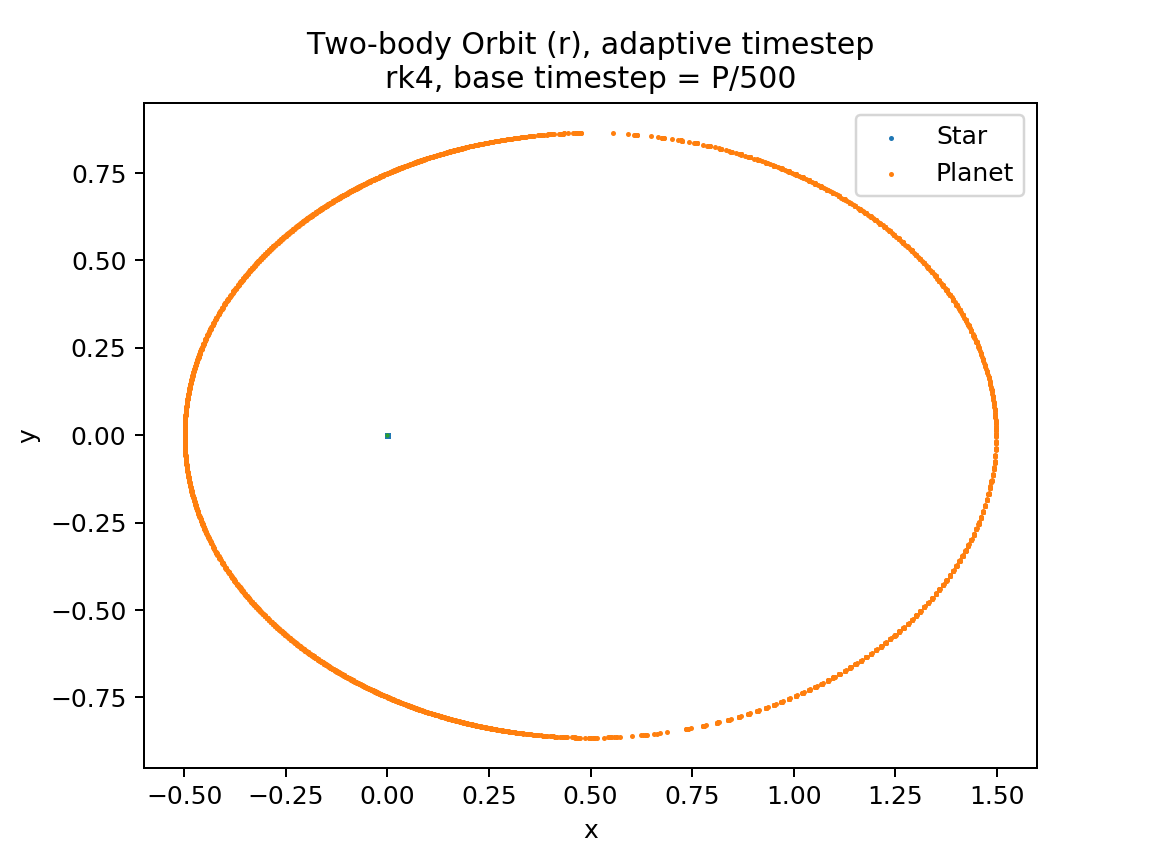

In [43]:
method = 'rk4'
res = locals()[method + '_res' + '_adaptive']
div = 500

ts = res[div][0]
rs = res[div][1]

r_fig = plt.figure()
plt.scatter(rs[:,0,0], rs[:,0,1], s=1, label="Star") # SUN --> (x,y)
plt.scatter(rs[:,1,0], rs[:,1,1], s=1, label="Planet") # PLANET --> (x,y)
plt.scatter(0,0, s=0.5)

plt.title("Two-body Orbit (r), adaptive timestep\n" + method + ", base timestep = P/" + str(div))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# filepath = savepath + "/orbit_" + str(div) + "_" + method + "_adaptive.pdf"
# if not os.path.isfile(filepath):
#     plt.savefig(filepath)
#     print("saved image")
# else: 
#     print("image already exists")

## Plotting the adaptive timestep over time --> optional, but could be a useful plot

<IPython.core.display.Javascript object>


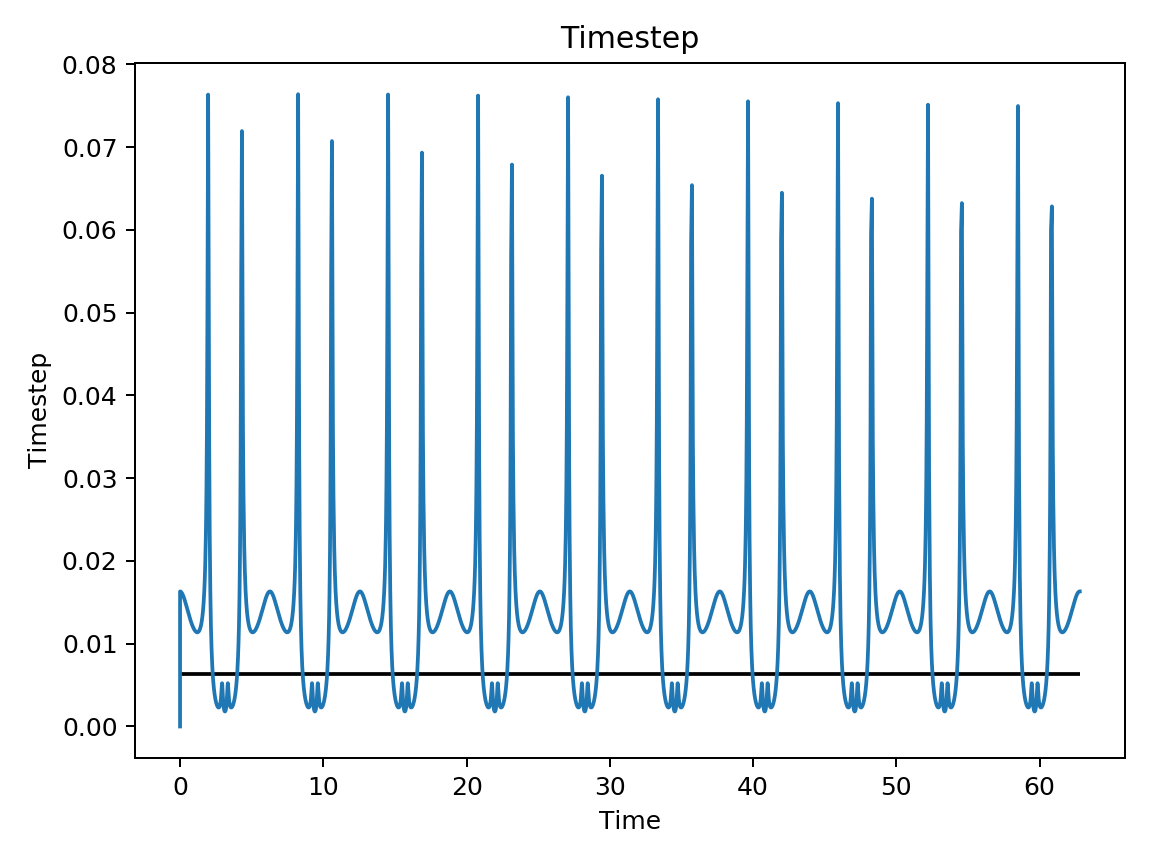

In [44]:
# Plotting the adaptive timestep
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

timestep_fig = plt.figure()
    
method = 'v_verlet'
div = 1000

ts = res[div][0]
Es = res[div][4]
kins = res[div][8]
pots = res[div][9]

shift = -np.min(pots)

diffs = ts[1:] - ts[:-1]

plt.hlines(2*np.pi/div, ts[0], ts[-1])
plt.plot(ts[:-1], diffs)

plt.title("Timestep")
plt.xlabel("Time")
plt.ylabel("Timestep")
#plt.legend()
plt.tight_layout()

#filepath = savepath + "/energy_comp_adaptive" + "_" + method + ".pdf"
#plt.savefig(filepath)
#print("saved image")

# 2.5 - Energy comparison between integrators with adaptive timestep --> optional

<IPython.core.display.Javascript object>


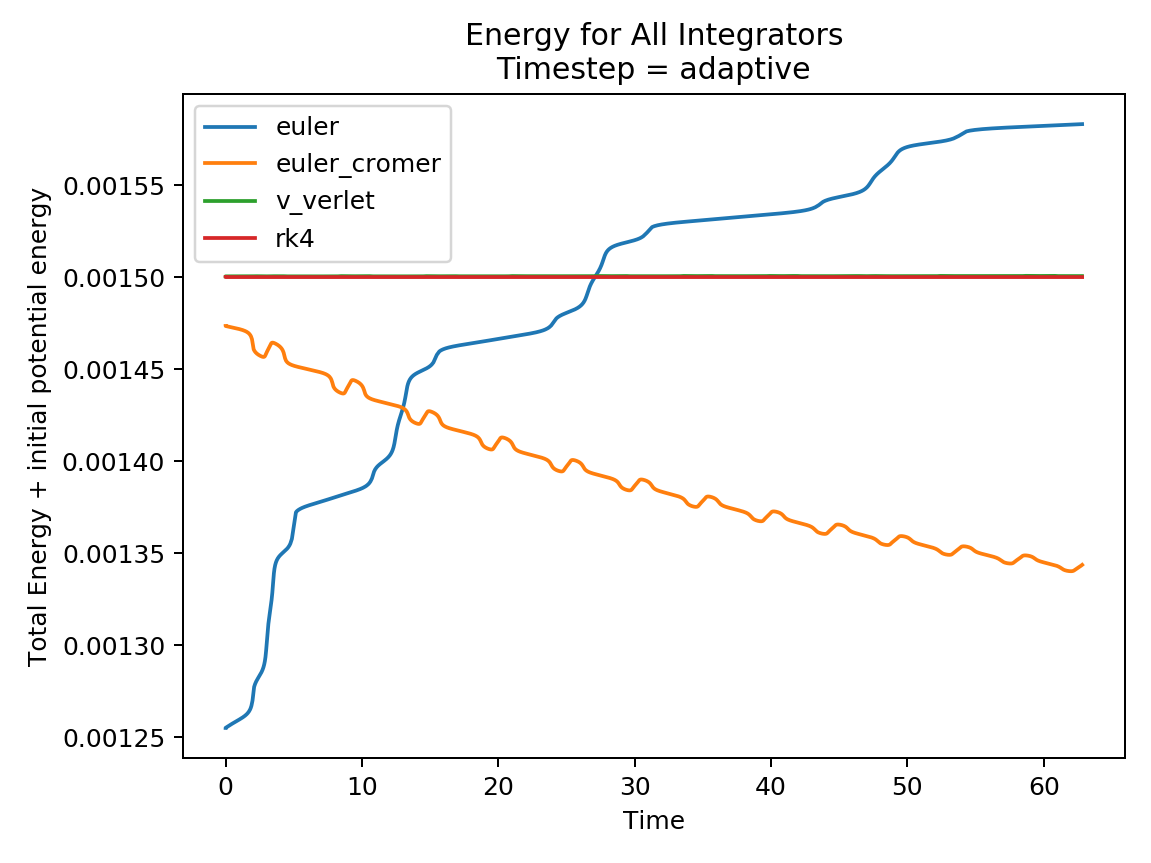

In [46]:
# Energy comparison between integrators
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

E_fig = plt.figure()
    
for method in methods:
    res = locals()[method + '_res' + '_adaptive']
    div = 500

    ts = res[div][0]
    Es = res[div][4]
    kins = res[div][8]
    pots = res[div][9]

    shift = -np.min(pots)

    plt.plot(ts, Es + shift, label=method)
    #plt.plot(ts, kins, label="Kinetic")
    #plt.plot(ts, pots + shift, label="Potential")

plt.title("Energy for All Integrators\nTimestep = adaptive")
plt.xlabel("Time")
plt.ylabel("Total Energy + initial potential energy")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/energy_comp_adaptive" + str(div) + ".pdf"
# plt.savefig(filepath)
# print("saved image")

# Ex. 2.5 - Energy comparison between fixed and adaptive timestep

<IPython.core.display.Javascript object>


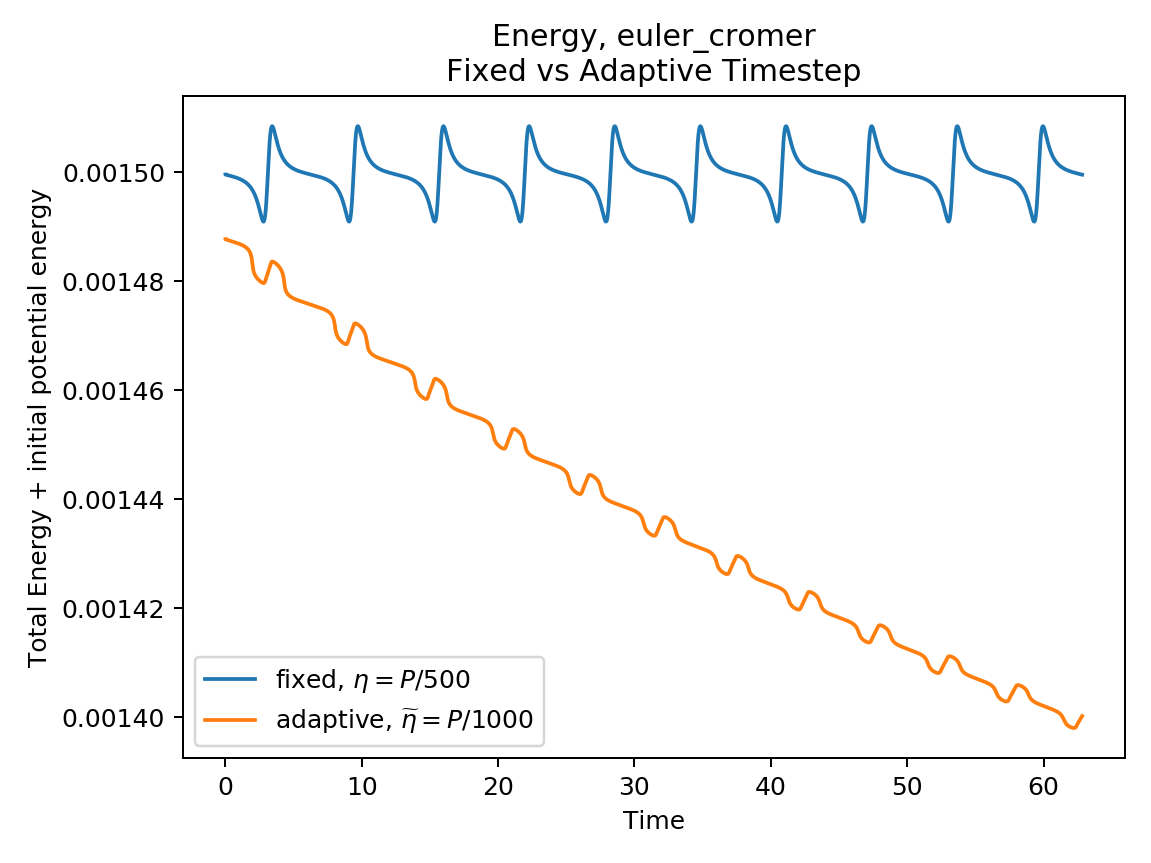

In [48]:
# Energy comparison between adaptive and fixed timestep
# [0:ts, 1:rs, 2:vs, 3:accs, 4:Es, 5:js, 6:es, 7:smas, 8:kins, 9:pots]
methods = ['euler', 'euler_cromer', 'v_verlet', 'rk4']

E_fig = plt.figure()

# PLOT FIXED
method = 'euler_cromer'
div = 500

res = locals()[method + '_res']
ts = res[div][0]
Es = res[div][4]
kins = res[div][8]
pots = res[div][9]

shift = -np.min(pots)

plt.plot(ts, Es + shift, label="fixed, $\eta=P/$" + str(div))

# PLOT ADAPTIVE (need to specify which div)
res = locals()[method + '_res' + '_adaptive']
div = 1000

ts = res[div][0]
Es = res[div][4]
kins = res[div][8]
pots = res[div][9]

shift = -np.min(pots)

plt.plot(ts, Es + shift, label="adaptive, $\widetilde{\eta}=P/$" + str(div))

plt.title("Energy, " + method + "\nFixed vs Adaptive Timestep")
plt.xlabel("Time")
plt.ylabel("Total Energy + initial potential energy")
plt.legend()
plt.tight_layout()

# filepath = savepath + "/energy_comp_fixed_vs_adaptive_greater" + "_" + method + ".pdf"
# plt.savefig(filepath)
# print("saved image")

# TODO: the rest of the plots for adaptive vs. fixed timestep

# Exericse 3: Three-body problem setup - not done yet sadly

In [52]:
def solve_three_body(integrator):
    # Number of spatial dimensions
    d = 2
    
    # Handle inital values and settings for two bodies
    n = 3               # Number of bodies
    P = 2*np.pi         # Period (given as 2pi)
    t_max = 10*P        # Time at which the integration ends
    G = 1.0

    # Initial values (1=star, 2=planet)
    m1 = 1.0     # Mass
    m2 = 10**-5
    m3 = 10**-5
    m = np.array([m1, m2, m3])

    delta = -0.0005
    
    e = np.array([0, 0])         # Eccentricity of orbits
    sma = np.array([1.0, 1.0 + delta])     # Semi-major axis
    
    params = {'n':n, 'd':d, 'G':G, 'm':m}
    
    # Initial position and velocity
    r0 = [0, 0]
    v0 = [0, 0]
    
    r1 = [-sma[0]*(1 + e[0]), 0]
    v1 = [0, np.sqrt((G*(m[0] + m[1])/sma[0])*((1-e[0])/(1+e[0])))]
    
    r2 = [sma[1]*(1 + e[1]), 0]
    v2 = [0, np.sqrt((G*(m[0] + m[2])/sma[1])*((1-e[1])/(1+e[1])))]
    
    init_r = [r0, r1, r2]
    init_v = [v0, v1, v2]
    
    r, v, a, E, j, e, sma, kins, pots = n_body_init(init_r, init_v, params, **params)
    dt = fixed_timestep(P)
    
    ts = []     # Time
    rs = []     # Position
    vs = []     # Velocity
    accs = []   # Acceleration
    Es = []     # Energy
    js = []     # Specific angular momentum
    es = []     # Runge-Lenz vector (eccentricity)
    smas = []   # Semi-major axis
    
    # Save initial values
    ts.append(0) 
    rs.append(r)
    vs.append(v)
    accs.append(a)
    Es.append(E)
    js.append(j)
    es.append(e)
    smas.append(sma)
    
    # Run the integrator
    t = 0
    
    prog = tqdm(total = t_max) # Progress bar
    
    start_time = time.time() # Measure how long the integrator takes
    
    while t < t_max:
        r, v, a = integrator(r, v, a, dt, params)
        kin, pot = calc_energy(r, v, **params)
        j = calc_angular_momentum(r, v)
        e = calc_runge_lenz(r, v, j, **params)
        sma = calc_sma(j, e, **params)
        t += dt
        
        ts.append(t) 
        rs.append(r)
        vs.append(v)
        accs.append(a)
        Es.append(E)
        js.append(j)
        es.append(e)
        smas.append(sma)
    
        prog.update(1) # increment progress bar
    
    end_time = time.time()
    time_elapsed = end_time - start_time
    
    print("Done!")
    print("Took: " + str(time_elapsed) + " seconds")
    
    ts = np.array(ts)
    rs = np.array(rs)
    vs = np.array(vs)
    accs = np.array(accs)
    Es = np.array(Es)
    js = np.array(js)
    es = np.array(es)
    smas = np.array(smas)
    
    return ts, rs, vs, accs, Es, js, es, smas

# Run here for 3 body

In [51]:
#ts, rs, vs, accs , Es, js, es, smas = solve_three_body(euler)
#ts, rs, vs, accs, Es, js, es, smas = solve_three_body(euler_cromer)
ts, rs, vs, accs, Es, js, es, smas, kins, pots = solve_three_body(v_verlet)
#ts, rs, vs, accs, Es, js, es, smas = solve_three_body(rk4)

/home/lmartini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


ValueError: too many values to unpack (expected 7)

# Orbit plot for 3-body

In [ ]:
r_fig = plt.figure()
plt.scatter(rs[:,0,0], rs[:,0,1], s=1, label="Star") # SUN --> (x,y)
plt.scatter(rs[:,1,0], rs[:,1,1], s=1, label="Planet1") # PLANET --> (x,y)
plt.scatter(rs[:,2,0], rs[:,2,1], s=1, label="Planet2") # PLANET --> (x,y)

plt.title("Orbit (r)")
plt.legend()

In [38]:
# file_name = "/mnt/c/Users/lmart/OneDrive/Documents/School/SS 2020/Praktikum/chaos_lab/figs/3bod_orbit_close.pdf"
# if not os.path.isfile(file_name):
#     plt.savefig(file_name)
#     print("saved file")
# print("file already saved")

# Ex. 3 - semi-major axis

<IPython.core.display.Javascript object>


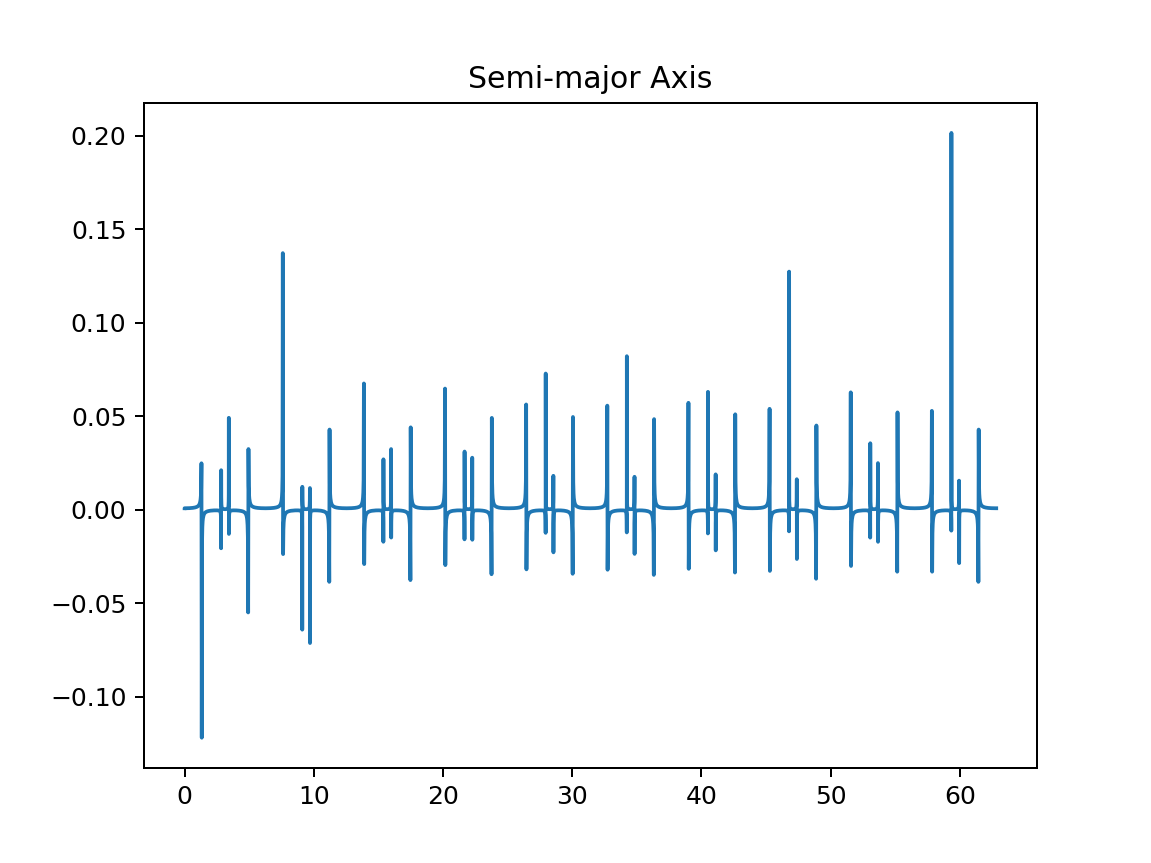

Text(0.5, 1.0, 'Semi-major Axis')

In [39]:
a_fig = plt.figure()
plt.plot(ts, smas[:,0])

#plt.legend()
plt.title("Semi-major Axis")

# Ex. 3 - eccentricity

<IPython.core.display.Javascript object>


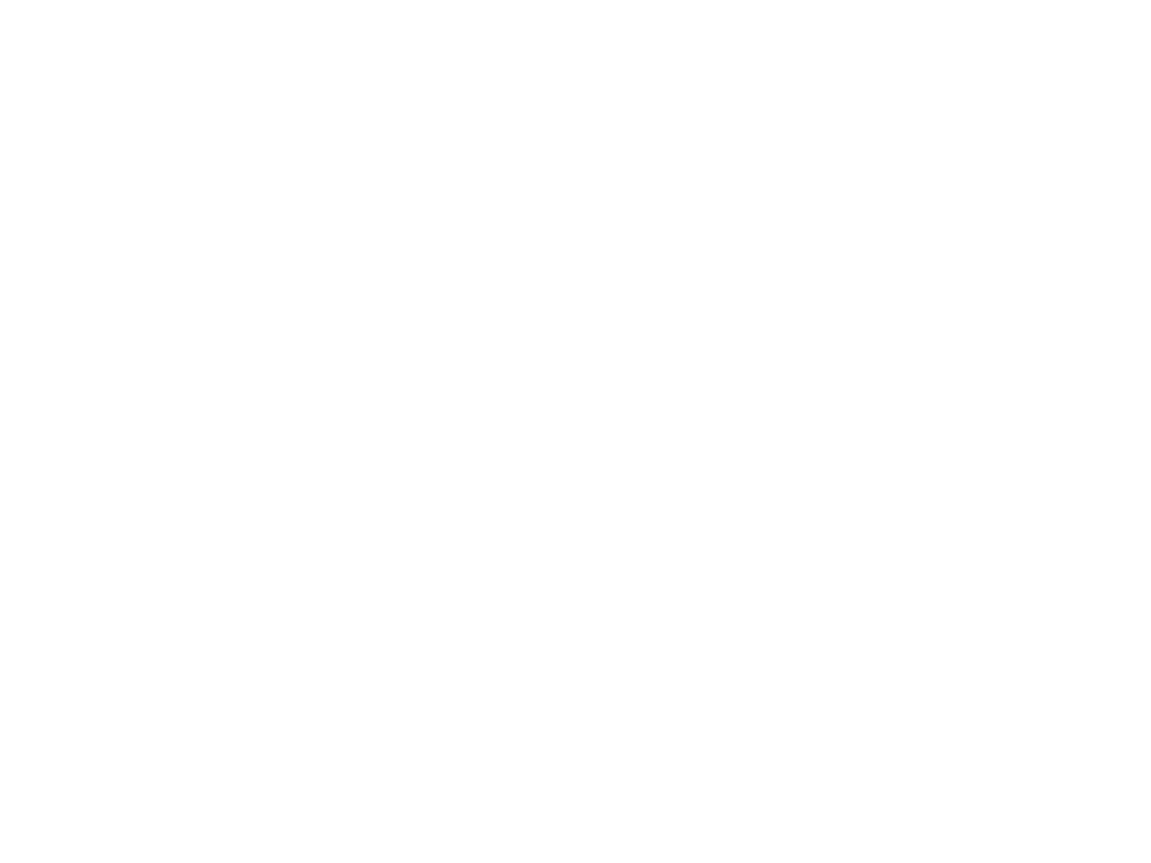

IndexError: index 2 is out of bounds for axis 1 with size 2

In [40]:
e_fig = plt.figure()

#plt.plot(ts, es[:,1,0], label="Planet x-dir")
#plt.plot(ts, es[:,1,1], label="Planet y-dir")
#plt.plot(ts, es[:,1], label="Planet")

e_vector_planet1 = []
for e in es[:,1]:
    e_vector_planet1.append(np.sqrt(e[0]**2 + e[1]**2))
                    
e_vector_planet2 = []
for e in es[:,2]:
    e_vector_planet2.append(np.sqrt(e[0]**2 + e[1]**2))
    
plt.plot(ts, e_vector_planet1, label="Planet 1")
plt.plot(ts, e_vector_planet2, label="Planet 2")
plt.legend()
plt.title("Runge-Lenz Vector (Eccentricity)")